## Bulk Si (FCC) model testing

In [59]:
import torch
import math
import numpy as np
import dscribe
from ase.build import molecule
from dscribe.descriptors import SOAP
from ase.io import read, write
from ase import Atom, Atoms
import time
import os
import sys
import pickle
from ase.io.cube import read_cube, write_cube
from sklearn.metrics import explained_variance_score, mean_squared_error
import py3Dmol
sys.path.append('deepcdp/')
from deepcdp import deepcdp
import torch.nn as nn
import torch.nn.functional as F
from torchsummaryX import summary
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import pandas as pd
import sklearn.metrics as skmetrics
from sklearn.neural_network import MLPRegressor
import gc
import zipfile
import pandas as pd
from tqdm import tqdm
from ase.build import bulk
from ase.visualize.plot import plot_atoms

import datetime
import matplotlib.pyplot as plt
import random
import torch.utils.data as utils_data
from torch.autograd import Variable
from torch.nn.modules.dropout import Dropout

import warnings
warnings.filterwarnings('ignore')

device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print("Device: ", device)

# This ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# This ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

Device:  mps
True
True


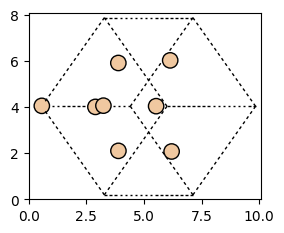

In [61]:
# generating an ASE Atoms object for Si
si_sample = read_cube(open('data/bulk-si/silicon8-ELECTRON_DENSITY-1_15.cube'))
si_ase=si_sample['atoms']
si_ase.set_pbc((True, True, True))
fig, ax = plt.subplots(figsize=(3,3))
plot_atoms(si_ase, ax, radii=0.3, rotation=('45x,45y,0z'))
plt.show()

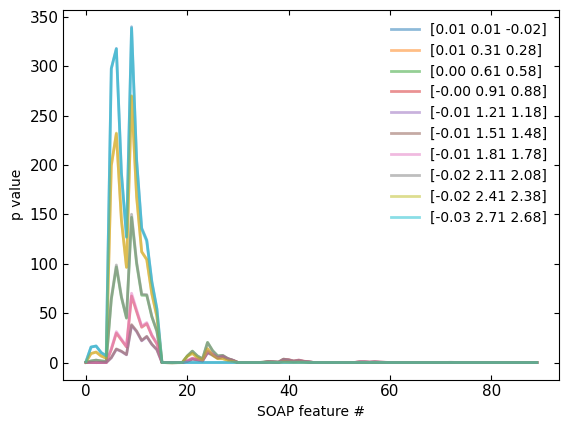

In [62]:
rcut = 10 # Local cut off
nmax = 5 # max number of radial basis functions
lmax = 5 # maximum degree of spherical harmonics

si_soap_W = SOAP( # W = with weighting
    species=['Si'],
    rcut=rcut,
    nmax=nmax,
    lmax=nmax,
    sigma=1,
    periodic=True,
    sparse=False,
    weighting={"function":"poly","r0":3,"c":4,"m":2}
)

# Samping 10 points from first Si atom to the second Si atom
x1, y1, z1 = si_ase.get_positions()[0]
x2, y2, z2 = si_ase.get_positions()[1]
num_points = 10

x_values = np.linspace(x1, x2, num_points)
y_values = np.linspace(y1, y2, num_points)
z_values = np.linspace(z1, z2, num_points)

pos_vector = [(x, y, z) for x, y, z in zip(x_values, y_values, z_values)]

# generating soap for each point
soap_si = si_soap_W.create(si_ase, positions = pos_vector)

# plotting and storing the mean soap value
mean_soap = []
for i in range(len(pos_vector)):
    x,y,z=pos_vector[i]
    plt.plot(soap_si[i],
             label = f'[{x:1.2f} {y:1.2f} {z:1.2f}]',
            alpha=0.5,
            linewidth=2)
    mean_soap += [np.mean(soap_si[i])]
plt.xlabel('SOAP feature #')
plt.ylabel('p value')
plt.legend(frameon=False)
plt.tick_params(direction = 'in', right = True, top = True)
plt.tick_params(axis='both', labelsize=11)
plt.tick_params(axis='both', labelsize=11)
plt.show()

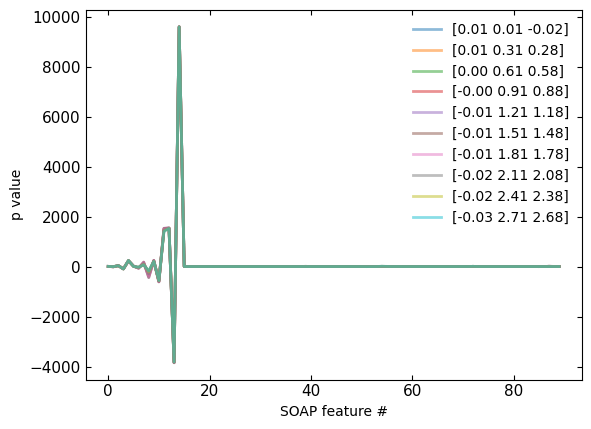

In [63]:
rcut = 10 # Local cut off
nmax = 5 # max number of radial basis functions
lmax = 5 # maximum degree of spherical harmonics

si_soap_noW = SOAP( # W = with weighting
    species=['Si'],
    rcut=rcut,
    nmax=nmax,
    lmax=nmax,
    sigma=1,
    periodic=True,
    sparse=False,
#     weighting={"function":"poly","r0":3,"c":4,"m":2}
)

# Samping 10 points from first Si atom to the second Si atom
x1, y1, z1 = si_ase.get_positions()[0]
x2, y2, z2 = si_ase.get_positions()[1]
num_points = 10

x_values = np.linspace(x1, x2, num_points)
y_values = np.linspace(y1, y2, num_points)
z_values = np.linspace(z1, z2, num_points)

pos_vector = [(x, y, z) for x, y, z in zip(x_values, y_values, z_values)]

# generating soap for each point
soap_si = si_soap_noW.create(si_ase, positions = pos_vector)

# plotting and storing the mean soap value
mean_soap = []
for i in range(len(pos_vector)):
    x,y,z=pos_vector[i]
    plt.plot(soap_si[i],
             label = f'[{x:1.2f} {y:1.2f} {z:1.2f}]',
            alpha=0.5,
            linewidth=2)
    mean_soap += [np.mean(soap_si[i])]
plt.xlabel('SOAP feature #')
plt.ylabel('p value')
plt.legend(frameon=False)
plt.tick_params(direction = 'in', right = True, top = True)
plt.tick_params(axis='both', labelsize=11)
plt.tick_params(axis='both', labelsize=11)
plt.show()

In [64]:
# Use the 6 DFT data points.
subsample=10

# Path of the file and filename prefix
datapath = 'data/bulk-si/'
datafilename = 'silicon8-ELECTRON_DENSITY-1_' 
all_files = os.listdir(f'{datapath}')
data_files =[x for x in all_files 
               if x.split('.')[-1] == 'cube']
idxList=[int(x.split('.cube')[0].split('_')[-1]) 
         for x in data_files if x.split('.')[-1] == 'cube']



cubefile = lambda x:f'{datapath}{x}' # creating a lambda function
print(idxList)
# generating an object of type deepcdp (imported)
CDP=deepcdp(si_soap_W)

# generates a box of points. Be mindful of the gamma value used.
CDP.create_box(sample_cubeFile=datapath+data_files[0], gamma=90)

totalfiles=int(os.popen(f'ls {datapath} | wc -l').read().split('\n')[0])

# useing ase's read_cube to read a sample cube file
dicttest=read_cube(open(datapath+data_files[0]))
sampleSubs=dicttest['atoms']
sampleSubs.set_pbc((True, True, True))

# randomly picking snapshots for training
data_files_sub = random.sample(data_files, k=subsample)

# generating final dataset
CDP.generate_cube_data(data_files_sub,cubefile,sampleSubs)


[445, 1460, 1840, 15, 1850, 695, 545, 1185, 1425, 1370, 830, 580, 390, 1970, 1675]
Read file: data/bulk-si/silicon8-ELECTRON_DENSITY-1_445.cube
SOAP is of dimension: (27000, 90)
Read file: data/bulk-si/silicon8-ELECTRON_DENSITY-1_1675.cube
Read file: data/bulk-si/silicon8-ELECTRON_DENSITY-1_545.cube
Read file: data/bulk-si/silicon8-ELECTRON_DENSITY-1_1185.cube
Read file: data/bulk-si/silicon8-ELECTRON_DENSITY-1_15.cube
Read file: data/bulk-si/silicon8-ELECTRON_DENSITY-1_1850.cube
Read file: data/bulk-si/silicon8-ELECTRON_DENSITY-1_695.cube
Read file: data/bulk-si/silicon8-ELECTRON_DENSITY-1_1425.cube
Read file: data/bulk-si/silicon8-ELECTRON_DENSITY-1_830.cube
Read file: data/bulk-si/silicon8-ELECTRON_DENSITY-1_1970.cube


(array([[7.33130278e-01, 1.42856613e+01, 1.53414638e+01, ...,
         3.62853404e-05, 2.84596981e-05, 2.24108974e-05],
        [6.48640346e-01, 1.29516874e+01, 1.41170469e+01, ...,
         6.22575310e-04, 4.75329644e-04, 3.63447917e-04],
        [4.46850719e-01, 9.63046031e+00, 1.09803522e+01, ...,
         2.44050795e-03, 1.83447988e-03, 1.37970644e-03],
        ...,
        [2.61312209e-01, 6.31978716e+00, 7.70332128e+00, ...,
         4.86091336e-03, 3.57451323e-03, 2.62912339e-03],
        [4.59866575e-01, 9.85025451e+00, 1.12074113e+01, ...,
         2.29349861e-03, 1.74040742e-03, 1.32182313e-03],
        [6.21649193e-01, 1.25169164e+01, 1.37137456e+01, ...,
         8.55668587e-04, 6.81471503e-04, 5.43463543e-04]]),
 array([0.0025744, 0.0067494, 0.023854 , ..., 0.042482 , 0.020399 ,
        0.0071408]))

In [65]:
soaps=Variable(torch.Tensor(CDP.trainX))
rhos=Variable(torch.Tensor(CDP.trainY))

In [66]:
# Define the model class

torch.manual_seed(1)

class NN(torch.nn.Module):        
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NN, self).__init__()
        hidden_1, hidden_2, hidden_3 = hidden_sizes
        layers = [
            nn.Linear(input_size, hidden_1),
#             nn.BatchNorm1d(hidden_1),
            nn.ReLU(),
            nn.Linear(hidden_1, hidden_2),
#             nn.BatchNorm1d(hidden_2),
            nn.ReLU(),
            nn.Linear(hidden_2, hidden_3),
#             nn.BatchNorm1d(hidden_3),
            nn.ReLU(),
            nn.Linear(hidden_3, output_size)
        ]
        
        self.layers = nn.Sequential(*layers)
        
#     def _init_weights(self, m):
#         for param in m.parameters():
#             nn.init.uniform_(param.data, -1, 1)
        

    def forward(self, A0):
        x = self.layers(A0)
        return x

In [67]:
batch_size=500
# Define the hyperparameters
num_epochs = 40
learning_rate = 1e-3

# Define the model and loss function
model = NN(soaps.shape[1], [300,300,300], 1).to(device)

# Defining loss function
criterion = nn.MSELoss() 

# Using the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate,
                             weight_decay=1e-4)

# Using a ReduceLROnPlateau scheduler on the loss function to tweak the LR.
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode="min", 
                                                       factor=0.5, 
                                                       patience=2, 
                                                       verbose=True, 
                                                       threshold=0.01)


training_samples = utils_data.TensorDataset(soaps, rhos)
data_loader_trn = utils_data.DataLoader(training_samples, 
                                        batch_size=batch_size, 
                                        drop_last=False, 
                                        shuffle=True)

In [68]:
model_dict=torch.load('sample-models/bulk-si-torch/bulk-si-39.pt')
model.load_state_dict(model_dict['model_state_dict'])
optimizer.load_state_dict(model_dict['optimizer_state_dict'])
scheduler.load_state_dict(model_dict['scheduler_state_dict'])

Epoch 1/40: Train Loss 34.5079, Learning Rate 0.0010


Epoch 2/40: Train Loss 0.0048, Learning Rate 0.0010
Training R2 value: 0.9927


Epoch 3/40: Train Loss 0.0021, Learning Rate 0.0010


Epoch 4/40: Train Loss 0.0054, Learning Rate 0.0010
Training R2 value: 0.9951


Epoch 5/40: Train Loss 0.0402, Learning Rate 0.0010
Saving model


Epoch 6/40: Train Loss 0.0058, Learning Rate 0.0010
Epoch 00006: reducing learning rate of group 0 to 5.0000e-04.
Training R2 value: 0.9942


Epoch 7/40: Train Loss 0.0011, Learning Rate 0.0005


Epoch 8/40: Train Loss 0.0010, Learning Rate 0.0005
Training R2 value: 0.9960


Epoch 9/40: Train Loss 0.0010, Learning Rate 0.0005


Epoch 10/40: Train Loss 0.0016, Learning Rate 0.0005
Epoch [10/40], Loss: 0.0016


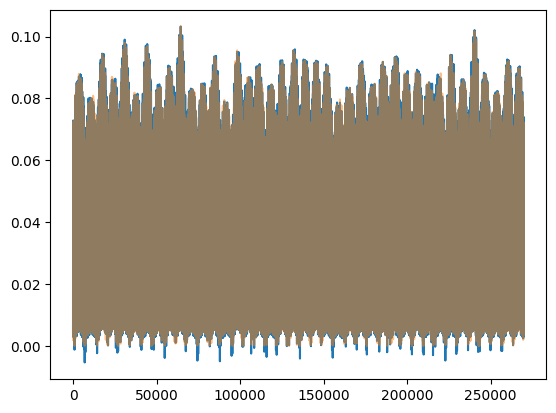

Training R2 value: 0.9951
Saving model


Epoch 11/40: Train Loss 0.0448, Learning Rate 0.0005


Epoch 12/40: Train Loss 0.0010, Learning Rate 0.0005
Epoch 00012: reducing learning rate of group 0 to 2.5000e-04.
Training R2 value: 0.9957


Epoch 13/40: Train Loss 0.0009, Learning Rate 0.0003


Epoch 14/40: Train Loss 0.0009, Learning Rate 0.0003
Training R2 value: 0.9961


Epoch 15/40: Train Loss 0.0012, Learning Rate 0.0003
Saving model


Epoch 16/40: Train Loss 0.0009, Learning Rate 0.0003
Training R2 value: 0.9965


Epoch 17/40: Train Loss 0.0010, Learning Rate 0.0003
Epoch 00017: reducing learning rate of group 0 to 1.2500e-04.


Epoch 18/40: Train Loss 0.0008, Learning Rate 0.0001
Training R2 value: 0.9966


Epoch 19/40: Train Loss 0.0009, Learning Rate 0.0001


Epoch 20/40: Train Loss 0.0009, Learning Rate 0.0001
Epoch [20/40], Loss: 0.0009


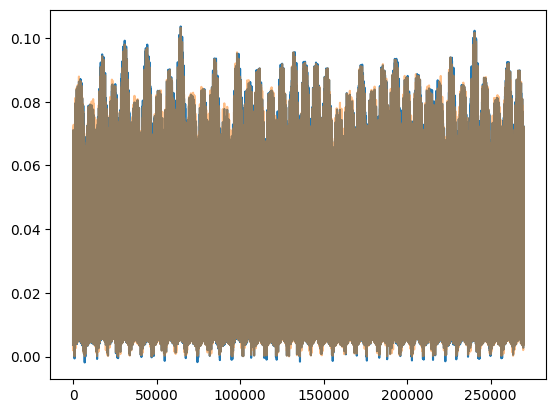

Training R2 value: 0.9965
Saving model


Epoch 21/40: Train Loss 0.0011, Learning Rate 0.0001
Epoch 00021: reducing learning rate of group 0 to 6.2500e-05.


Epoch 22/40: Train Loss 0.0009, Learning Rate 0.0001
Training R2 value: 0.9964


Epoch 23/40: Train Loss 0.0009, Learning Rate 0.0001


Epoch 24/40: Train Loss 0.0010, Learning Rate 0.0001
Epoch 00024: reducing learning rate of group 0 to 3.1250e-05.
Training R2 value: 0.9960


Epoch 25/40: Train Loss 0.0009, Learning Rate 0.0000
Saving model


Epoch 26/40: Train Loss 0.0009, Learning Rate 0.0000
Training R2 value: 0.9964


Epoch 27/40: Train Loss 0.0009, Learning Rate 0.0000
Epoch 00027: reducing learning rate of group 0 to 1.5625e-05.


Epoch 28/40: Train Loss 0.0009, Learning Rate 0.0000
Training R2 value: 0.9964


Epoch 29/40: Train Loss 0.0009, Learning Rate 0.0000


Epoch 30/40: Train Loss 0.0009, Learning Rate 0.0000
Epoch 00030: reducing learning rate of group 0 to 7.8125e-06.
Epoch [30/40], Loss: 0.0009


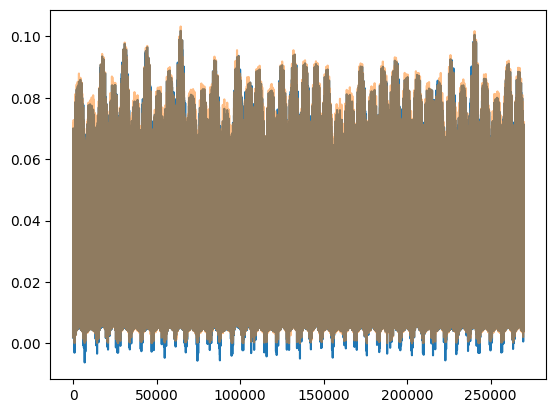

Training R2 value: 0.9961
Saving model


Epoch 31/40: Train Loss 0.0009, Learning Rate 0.0000


Epoch 32/40: Train Loss 0.0009, Learning Rate 0.0000
Training R2 value: 0.9962


Epoch 33/40: Train Loss 0.0009, Learning Rate 0.0000
Epoch 00033: reducing learning rate of group 0 to 3.9063e-06.


Epoch 34/40: Train Loss 0.0009, Learning Rate 0.0000
Training R2 value: 0.9962


Epoch 35/40: Train Loss 0.0009, Learning Rate 0.0000
Saving model


Epoch 36/40: Train Loss 0.0009, Learning Rate 0.0000
Epoch 00036: reducing learning rate of group 0 to 1.9531e-06.
Training R2 value: 0.9962


Epoch 37/40: Train Loss 0.0009, Learning Rate 0.0000


Epoch 38/40: Train Loss 0.0009, Learning Rate 0.0000
Training R2 value: 0.9962


Epoch 39/40: Train Loss 0.0009, Learning Rate 0.0000
Epoch 00039: reducing learning rate of group 0 to 9.7656e-07.


Epoch 40/40: Train Loss 0.0009, Learning Rate 0.0000
Epoch [40/40], Loss: 0.0009


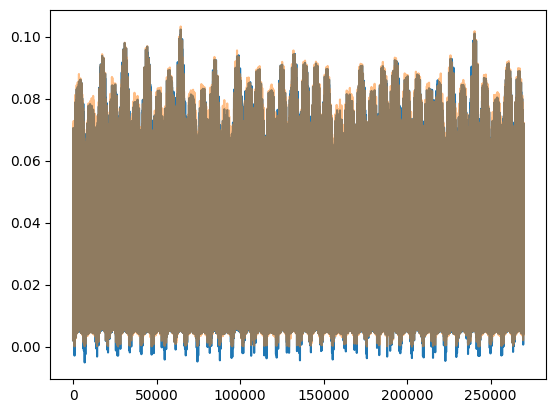

Training R2 value: 0.9961
Saving model


In [41]:
# Train the model
cum_loss_epoch=[]
for epoch in range(num_epochs):
    batch_bar = tqdm(total=len(data_loader_trn), dynamic_ncols=True, leave=False, position=0, desc='Train') 
    model.train()
    cum_loss = 0
    # Convert inputs and labels to tensors
    
    for batch_idx, (data, target) in enumerate(data_loader_trn):
        inputs = (data.float()).to(device)
        labels = (target.float()).reshape(-1,1).to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cum_loss+=loss.item()
        batch_bar.set_postfix(
            loss="{:.04f}".format(cum_loss),
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])))
        batch_bar.update()
    batch_bar.close()
    print("Epoch {}/{}: Train Loss {:.04f}, Learning Rate {:.04f}".format(
        epoch + 1,
        num_epochs,
        float(cum_loss), 
        float(float(optimizer.param_groups[0]['lr']))
        ))

    scheduler.step(cum_loss)
    cum_loss_epoch +=[cum_loss]
    np.savetxt('sample-models/bulk-si-torch/cum_loss-kp.dat',cum_loss_epoch)

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {cum_loss:.4f}')
        plt.plot(model(soaps.to(device)).cpu().detach().numpy())
        plt.plot(rhos, alpha=0.5)
        plt.show()

    if (epoch+1)%2==0:
        model.eval()
        acc=skmetrics.r2_score(model(soaps.to(device)).cpu().detach().numpy(),rhos)
        print(f"Training R2 value: {acc:1.4f}")
        
    if (epoch+1) % 5 == 0:
        
        print('Saving model')
        torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict' : scheduler.state_dict(),
    }, f"sample-models/bulk-si-torch/bulk-si-kp-"+str(epoch)+".pt")
#     print()

In [70]:
model.eval()
# Testing 0 Cu structure
test_cube_path = 'data/bulk-si/silicon8-ELECTRON_DENSITY-1_1185.cube'
test_cube = read_cube(open(test_cube_path))
ase_atoms_test = test_cube['atoms']
ase_atoms_test.set_pbc((True, True, True))
pos_atoms_test = ase_atoms_test.get_positions()
rho_test = test_cube['data']
rho_test = rho_test.ravel().reshape(-1,1)

start = time.time()
soap_test = si_soap_W.create(ase_atoms_test, positions=CDP.box)
rho_pred = model(torch.tensor(soap_test, dtype=torch.float32).to(device)).cpu().detach().numpy()

end = time.time()
print("Prediction time: ", (end - start), " seconds.")
print(f'R2 value: {skmetrics.r2_score(rho_test,rho_pred):1.2f}')
print(f'MSE value: {skmetrics.mean_squared_error(rho_test,rho_pred):1.5f}')


Prediction time:  5.469372987747192  seconds.
R2 value: 0.99
MSE value: 0.00000


In [71]:
print(f'MSE value: {skmetrics.mean_squared_error(rho_test,rho_pred):1.7f}')

MSE value: 0.0000033


In [44]:
out=open('example/predictions/bulk-si/pred-1185-torch.cube','w+')
rho_test_resp = rho_pred.reshape(*CDP.bounds)
write_cube(out,ase_atoms_test,rho_test_resp,origin=CDP.box[0])

In [45]:
si_cube_predict=open('example/predictions/bulk-si/pred-1185-torch.cube').read()
si_cube_dft=open(test_cube_path).read()
CDP.cube2xyz(test_cube_path,'example/structures/bulk-si/si-1185.xyz')
isoval=0.009
si_xyz=open('example/structures/bulk-si/si-1185.xyz').read()
xyzview = py3Dmol.view(width=400,height=400)
xyzview.addVolumetricData(si_cube_predict,'cube',{'isoval': isoval,"color":'red','opacity':1,'wireframe':True})
xyzview.addVolumetricData(si_cube_dft,'cube',{'isoval': isoval,"color":'grey','opacity':1,'wireframe':True})
# xyzview.addModel(cu_xyz,'xyz')
xyzview.setStyle({'stick':{}})
xyzview.zoomTo()
xyzview.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [46]:
rho_test_resp.shape
rho_test = test_cube['data']
error = np.abs(rho_test - rho_test_resp)
out=open('example/predictions/bulk-si/error-1185-torch.cube','w+')
write_cube(out,ase_atoms_test,error,origin=CDP.box[0])

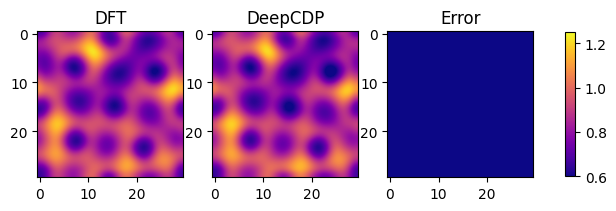

In [58]:
vmin = 0.6
vmax = 1.25
plt.subplot(131)
plt.imshow(np.trapz(rho_test, axis=2 ), cmap='plasma',
           interpolation ='spline36', vmin=vmin, vmax=vmax)
plt.title('DFT')
plt.subplot(132)
plt.imshow(np.trapz(rho_test_resp, axis=2 ), cmap='plasma',
           interpolation ='spline36', vmin=vmin, vmax=vmax)
plt.title('DeepCDP')
plt.subplot(133)
plt.imshow(np.trapz(error, axis=2 ), cmap='plasma',
           interpolation ='spline36', vmin=vmin, vmax=vmax)
plt.title('Error')
plt.subplots_adjust(bottom=0.0, right=0.9, top=0.9)
cax = plt.axes([0.95, 0.3, 0.015, 0.3])
plt.colorbar(cax=cax)
# plt.show()
plt.savefig('Images/Si-example.png',dpi=600,bbox_inches="tight",)

## Without weighting

In [52]:
# Use the 6 DFT data points.
subsample=10

# Path of the file and filename prefix
datapath = 'data/bulk-si/'
datafilename = 'Si-fcc--ELECTRON_DENSITY-1_' 
all_files = os.listdir(f'{datapath}')
data_files =[x for x in all_files 
               if x.split('.')[-1] == 'cube']
idxList=[int(x.split('.cube')[0].split('_')[-1]) 
         for x in data_files if x.split('.')[-1] == 'cube']



cubefile = lambda x:f'{datapath}{x}' # creating a lambda function
print(idxList)
# generating an object of type deepcdp (imported)
CDP2=deepcdp(si_soap_noW)

# generates a box of points. Be mindful of the gamma value used.
CDP2.create_box(sample_cubeFile=datapath+data_files[0], gamma=90)

totalfiles=int(os.popen(f'ls {datapath} | wc -l').read().split('\n')[0])

# useing ase's read_cube to read a sample cube file
dicttest=read_cube(open(datapath+data_files[0]))
sampleSubs=dicttest['atoms']
sampleSubs.set_pbc((True, True, True))

# randomly picking snapshots for training
data_files_sub = random.sample(data_files, k=subsample)

# generating final dataset
CDP2.generate_cube_data(data_files_sub,cubefile,sampleSubs)


[445, 1460, 1840, 15, 1850, 695, 545, 1185, 1425, 1370, 830, 580, 390, 1970, 1675]
Read file: data/bulk-si/silicon8-ELECTRON_DENSITY-1_445.cube
SOAP is of dimension: (27000, 90)
Read file: data/bulk-si/silicon8-ELECTRON_DENSITY-1_1460.cube
Read file: data/bulk-si/silicon8-ELECTRON_DENSITY-1_1970.cube
Read file: data/bulk-si/silicon8-ELECTRON_DENSITY-1_390.cube
Read file: data/bulk-si/silicon8-ELECTRON_DENSITY-1_1675.cube
Read file: data/bulk-si/silicon8-ELECTRON_DENSITY-1_1370.cube
Read file: data/bulk-si/silicon8-ELECTRON_DENSITY-1_580.cube
Read file: data/bulk-si/silicon8-ELECTRON_DENSITY-1_1850.cube
Read file: data/bulk-si/silicon8-ELECTRON_DENSITY-1_1185.cube
Read file: data/bulk-si/silicon8-ELECTRON_DENSITY-1_1840.cube


(array([[ 6.04349077e+00, -4.76453758e+00,  3.40611575e+01, ...,
          1.25659241e-01, -2.38419122e-01,  5.36899528e-01],
        [ 6.00354153e+00, -4.87462207e+00,  3.39609376e+01, ...,
          6.23308368e-01, -3.37030762e-02,  6.15945121e-01],
        [ 5.91158703e+00, -5.25079101e+00,  3.38268336e+01, ...,
          1.92440017e+00,  4.67915068e-01,  8.00105657e-01],
        ...,
        [ 5.74338906e+00, -5.66638986e+00,  3.54357017e+01, ...,
          5.13053994e+00,  1.99101676e+00,  1.00033051e+00],
        [ 5.81933306e+00, -5.08839525e+00,  3.53699996e+01, ...,
          3.34814110e+00,  1.34583252e+00,  7.93725683e-01],
        [ 5.86556690e+00, -4.75651638e+00,  3.52997933e+01, ...,
          1.90262496e+00,  7.77271526e-01,  6.05186848e-01]]),
 array([0.0025744, 0.0067494, 0.023854 , ..., 0.04713  , 0.033535 ,
        0.025652 ]))

In [53]:
soaps=Variable(torch.Tensor(CDP2.trainX))
rhos=Variable(torch.Tensor(CDP2.trainY))

In [54]:
# Define the model class

torch.manual_seed(1)

class NN(torch.nn.Module):        
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NN, self).__init__()
        hidden_1, hidden_2, hidden_3 = hidden_sizes
        layers = [
            nn.Linear(input_size, hidden_1),
#             nn.BatchNorm1d(hidden_1),
            nn.ReLU(),
            nn.Linear(hidden_1, hidden_2),
#             nn.BatchNorm1d(hidden_2),
            nn.ReLU(),
            nn.Linear(hidden_2, hidden_3),
#             nn.BatchNorm1d(hidden_3),
            nn.ReLU(),
            nn.Linear(hidden_3, output_size)
        ]
        
        self.layers = nn.Sequential(*layers)
        
#     def _init_weights(self, m):
#         for param in m.parameters():
#             nn.init.uniform_(param.data, -1, 1)
        

    def forward(self, A0):
        x = self.layers(A0)
        return x

In [55]:
batch_size=500
# Define the hyperparameters
num_epochs = 10 # Let's train the model for just 10 epoch as we did attain 
# a high R2 value at such low epochs
learning_rate = 1e-3

# Define the model and loss function
model = NN(soaps.shape[1], [300,300,300], 1).to(device)

# Defining loss function
criterion = nn.MSELoss() 

# Using the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate,
                             weight_decay=1e-4)

# Using a ReduceLROnPlateau scheduler on the loss function to tweak the LR.
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode="min", 
                                                       factor=0.5, 
                                                       patience=2, 
                                                       verbose=True, 
                                                       threshold=0.01)


training_samples = utils_data.TensorDataset(soaps, rhos)
data_loader_trn = utils_data.DataLoader(training_samples, 
                                        batch_size=batch_size, 
                                        drop_last=False, 
                                        shuffle=True)

Epoch 1/10: Train Loss 87717.8997, Learning Rate 0.0010


Epoch 2/10: Train Loss 26.4941, Learning Rate 0.0010
Training R2 value: -0.0008


Epoch 3/10: Train Loss 2.3116, Learning Rate 0.0010


Epoch 4/10: Train Loss 51.6487, Learning Rate 0.0010
Training R2 value: 0.1003


Epoch 5/10: Train Loss 0.5185, Learning Rate 0.0010
Saving model


Epoch 6/10: Train Loss 0.7199, Learning Rate 0.0010
Training R2 value: 0.3060


Epoch 7/10: Train Loss 158.1396, Learning Rate 0.0010


Epoch 8/10: Train Loss 65.7137, Learning Rate 0.0010
Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.
Training R2 value: -0.1771


Epoch 9/10: Train Loss 0.9254, Learning Rate 0.0005


Epoch 10/10: Train Loss 0.3152, Learning Rate 0.0005
Epoch [10/10], Loss: 0.3152


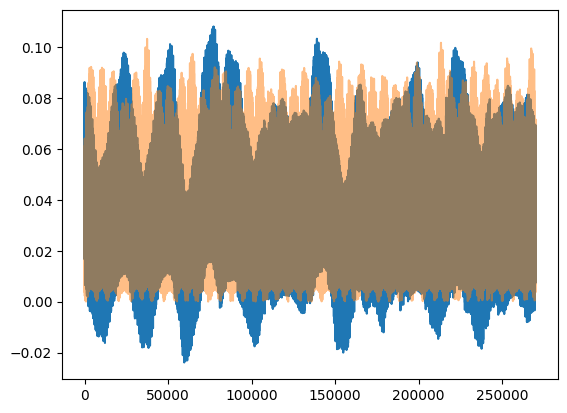

Training R2 value: 0.4061
Saving model


In [56]:
# Train the model
cum_loss_epoch=[]
for epoch in range(num_epochs):
    batch_bar = tqdm(total=len(data_loader_trn), dynamic_ncols=True, leave=False, position=0, desc='Train') 
    model.train()
    cum_loss = 0
    # Convert inputs and labels to tensors
    
    for batch_idx, (data, target) in enumerate(data_loader_trn):
        inputs = (data.float()).to(device)
        labels = (target.float()).reshape(-1,1).to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cum_loss+=loss.item()
        batch_bar.set_postfix(
            loss="{:.04f}".format(cum_loss),
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])))
        batch_bar.update()
    batch_bar.close()
    print("Epoch {}/{}: Train Loss {:.04f}, Learning Rate {:.04f}".format(
        epoch + 1,
        num_epochs,
        float(cum_loss), 
        float(float(optimizer.param_groups[0]['lr']))
        ))

    scheduler.step(cum_loss)
    cum_loss_epoch +=[cum_loss]
    np.savetxt('sample-models/bulk-si-torch/cum_loss_noW.dat',cum_loss_epoch)

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {cum_loss:.4f}')
        plt.plot(model(soaps.to(device)).cpu().detach().numpy())
        plt.plot(rhos, alpha=0.5)
        plt.show()

    if (epoch+1)%2==0:
        model.eval()
        acc=skmetrics.r2_score(model(soaps.to(device)).cpu().detach().numpy(),rhos)
        print(f"Training R2 value: {acc:1.4f}")
        
    if (epoch+1) % 5 == 0:
        
        print('Saving model')
        torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict' : scheduler.state_dict(),
    }, f"sample-models/bulk-si-torch/bulk-si-noW-"+str(epoch)+".pt")
#     print()

Model fail terribly without the weighting function